In [2]:
# Set a root directory
import os
import sys 
os.chdir("/Users/evgenii/Documents/Workspace/TCR/TITAN_dev/")
sys.path[0] = "/Users/evgenii/Documents/Workspace/TCR/TITAN_dev/"

In [3]:
# Notebook to evaluate K-NN baseline on cross validation
"""
Evaluate lazy KNN baseline predictor in a Cross-Validation setting.
Can be used in 2 modes.
    - shared    : Assumes that epitope_fp and tcr_fp contain all epitopes and tcrs that
        are used in training and testng dataset.
    - separate  : Assumes that two paths are passed for both TCRs and epitopes.
        - epitope_fp: Path to file containing all epitopes used in training.
        - epitope_test_fp: Path to file containing all epitopes used in testing.
        - tcr_fp: Path to file containing all TCRs used in training.
        - tcr_test_fp: Path to file containing all TCRs used in testing.

The default mode is 'shared' which is used iff the two optional args '-test_ep' and
'-test_tcr' are left empty (i.e., their default).
"""
import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
from pytoda.files import read_smi
from sklearn.metrics import (
    accuracy_score, auc, average_precision_score, balanced_accuracy_score,
    confusion_matrix, matthews_corrcoef, precision_score, roc_curve
)

In [5]:
from source.models import knn
from source.utils.plot_knn import plot_roc_prc
from source.utils.utils import cutoff_youdens_j

In [11]:
# python3 scripts/knn_cv.py \
# -d path_to_data_folder \
# -tr name_of_training_data_files.csv \
# -te name_of_testing_data_files.csv \
# -f 10 \
# -ep path_to_epitope_file.ccsv \
# -tcr path_to_tcr_file.csv \
# -r path_to_result_folder \
# -k 25


# args.data_path, args.train_name, args.test_name, args.num_folds,
#         args.epitope_fp, args.tcr_fp, args.results_path, args.k,
#         args.test_epitope_fp, args.test_tcr_fp

# Arguments to pass
logger = logging.getLogger('knn_prediction')
logging.getLogger('matplotlib.font_manager').disabled = True

data_path = "data/preprocessed/tcr_split/"
train_name = "train.csv"
test_name = "test.csv"
num_folds = 10

results_path = "results/knn_model/"
k = 25
test_epitope_fp = '.'
test_tcr_fp = '.'

In [7]:
# All the available datapoints from datasets
epitope_fp = "data/raw/epitopes.csv"
tcr_fp = "data/raw/tcr.csv"

# Function read a .smi (or .csv file with tab-separated values) in a pd.DataFrame.
train_epi = read_smi(epitope_fp, names=['data'])
train_tcr = read_smi(tcr_fp, names=['data'])

# test_epitope_fp is not required. It is optional
test_epi = train_epi if test_epitope_fp == '.' else read_smi(
    test_epitope_fp, names=['data']
)
test_tcr = train_tcr if test_tcr_fp == '.' else read_smi(
    test_tcr_fp, names=['data']
)

In [12]:
train_tcr

,data
2,CSATILAGVPYGEQYF
3,CSASEGTSSYEQYF
4,CASSFDREVTGELFF
5,CASSVGAGTEAFF
6,CAISESGYGGPPGANVLTF
...,...
23140,CASPDGWGYTF
23141,CASSGAPLLEQYF
23142,CASSPSGTFYEQYF
23143,CSVWGTGKTYEQYF


In [13]:
# Create right amount of empty lists
# K for the KNN classification. Note that classification reports are generated
all_results = np.empty((np.ceil(k / 2).astype(int), 0)).tolist()
all_results

[[], [], [], [], [], [], [], [], [], [], [], [], []]

In [14]:
# Loop through each folder
for fold in range(num_folds):
    train_data = pd.read_csv(
        os.path.join(data_path, f'fold{fold}', train_name), index_col=0
    )
    test_data = pd.read_csv(
        os.path.join(data_path, f'fold{fold}', test_name), index_col=0
    )

    # Read each folder indices for train/test from tcr_fp/epitope_fp (overall data)
    train_epitopes = train_epi.loc[train_data['ligand_name']]['data']
    train_tcrs = train_tcr.loc[train_data['sequence_id']]['data']
    test_epitopes = test_epi.loc[test_data['ligand_name']]['data']
    test_tcrs = test_tcr.loc[test_data['sequence_id']]['data']
    train_labels = train_data['label']
    test_labels = test_data['label']

    # Originally imported class. Pasted in the cell below
    # # Classify data
    # predictions, knn_labels = knn(
    #     train_epitopes,
    #     train_tcrs,
    #     train_labels,
    #     test_epitopes,
    #     test_tcrs,
    #     k=k,
    #     return_knn_labels=True,
    # )
    
    logger.info(f'Fold {fold}: Data loaded')
    break

In [15]:
# KNN code
from typing import Iterable, List

import numpy as np
from Levenshtein import distance as levenshtein_distance

return_knn_labels = False

assert isinstance(train_epitopes, Iterable)
assert isinstance(train_tcrs, Iterable)
assert isinstance(train_labels, Iterable)
assert isinstance(test_epitopes, Iterable)
assert isinstance(test_tcrs, Iterable)

assert len(test_tcrs) == len(test_epitopes), 'Test data lengths dont match'
assert len(train_epitopes
            ) == len(train_tcrs), 'Test data lengths dont match'
assert len(train_epitopes
            ) == len(train_labels), 'Test data lengths dont match'

print(f"len(train_tcrs): {len(train_tcrs)}, len(test_tcrs): {len(test_tcr)} ")

predictions, knn_labels = [], []
for epitope, tcr in zip(test_epitopes, test_tcrs):

    el = len(epitope)
    tl = len(tcr)
    # print(f"len(tcr): {len(tcr)}, len(epitope): {len(epitope)} ")


    # Calculate the distances
    epitope_dists = [
        levenshtein_distance(epitope, e) / el for e in train_epitopes
    ]
    tcr_dists = [levenshtein_distance(tcr, t) / tl for t in train_tcrs]

    # Get the closest k (neighbours) -> Sorted by distances; Get their indices
    knns = np.argsort(np.array(epitope_dists) + np.array(tcr_dists))[:k]
    
    # Get the labels of the above indices
    _knn_labels = np.array(train_labels)[knns]
    # We only 2 classes so we can just take a mean
    predictions.append(np.mean(_knn_labels))
    knn_labels.append(_knn_labels)

    # break # 1 loop test


len(train_tcrs): 19078, len(test_tcrs): 23143 


In [16]:
knns

array([13317, 18977, 10171, 14833, 12393,  2379, 19072, 12516, 19002,
       18276, 12377, 17782, 13707,   943, 10437, 17971, 12380, 14503,
       12808, 19003,  1955,  2346, 18121,  2422,  1811])

In [17]:
_knn_labels

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1])

In [18]:
np.mean(_knn_labels)

0.24

In [19]:
print(predictions[:3], len(predictions))

[0.68, 0.64, 0.12] 2120


In [20]:
for idx, _k in enumerate(range(k, 0, -2)):
    print(idx, _k)

0 25
1 23
2 21
3 19
4 17
5 15
6 13
7 11
8 9
9 7
10 5
11 3
12 1


In [21]:
for idx, _k in enumerate(range(k, 0, -2)):

    # Evaluation process
    print(f"idx: {idx}, k: {_k}")

    # Overwrite predictions to match _k instead of k
    _predictions = [
        np.mean(sample_knns[:_k]) for sample_knns in knn_labels
    ]
    print(f"_predictions:{_predictions[:10]}, len(_predictions):{len(_predictions)}")

    # Compute metrics
    #   Continuous metrics
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    roc_auc = auc(fpr, tpr)
    precision_recall_score = average_precision_score(
        test_labels, predictions
    )

    #   Metrics for a truly binary classifier
    theta = cutoff_youdens_j(fpr, tpr, thresholds)
    binary_predictions = [p > theta for p in predictions]
    accuracy = accuracy_score(test_labels, binary_predictions)
    balanced_accuracy = balanced_accuracy_score(
        test_labels, binary_predictions
    )

    precision = precision_score(test_labels, binary_predictions)
    mcc = matthews_corrcoef(test_labels, binary_predictions)
    tn, fp, fn, tp = confusion_matrix(test_labels,
                                        binary_predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    if _k != 1:
        # Needed to handle NaN case.
        assert max(
            0, precision == (tp / (tp + fp))
        ), 'Metrics dont match.'

    # Create and save json
    results = {
        'ROC-AUC': roc_auc,
        'Precision-Recall': precision_recall_score,
        'MCC': mcc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'Precision': precision,
        'theta': theta,
    }
    print(results)
    print('-' * 60)
    

idx: 0, k: 25
_predictions:[0.68, 0.64, 0.12, 0.36, 0.32, 0.48, 0.64, 0.56, 0.56, 0.64], len(_predictions):2120
{'ROC-AUC': 0.8055469028123888, 'Precision-Recall': 0.7816468510297911, 'MCC': 0.48171205678560797, 'Sensitivity': 0.7160377358490566, 'Specificity': 0.7650943396226415, 'Accuracy': 0.7405660377358491, 'Balanced Accuracy': 0.7405660377358491, 'Precision': 0.7529761904761905, 'theta': 0.56}
------------------------------------------------------------
idx: 1, k: 23
_predictions:[0.6521739130434783, 0.6521739130434783, 0.13043478260869565, 0.391304347826087, 0.34782608695652173, 0.4782608695652174, 0.6521739130434783, 0.5217391304347826, 0.5652173913043478, 0.6521739130434783], len(_predictions):2120
{'ROC-AUC': 0.8055469028123888, 'Precision-Recall': 0.7816468510297911, 'MCC': 0.48171205678560797, 'Sensitivity': 0.7160377358490566, 'Specificity': 0.7650943396226415, 'Accuracy': 0.7405660377358491, 'Balanced Accuracy': 0.7405660377358491, 'Precision': 0.7529761904761905, 'theta'

### Run the code as one module

In [ ]:
# Set a root directory
import os
import sys 
os.chdir("/Users/evgenii/Documents/Workspace/TCR/TITAN_dev/")
sys.path[0] = "/Users/evgenii/Documents/Workspace/TCR/TITAN_dev/"

{'ROC-AUC': 0.8055469028123888, 'Precision-Recall': 0.7816468510297911, 'MCC': 0.48171205678560797, 'Sensitivity': 0.7160377358490566, 'Specificity': 0.7650943396226415, 'Accuracy': 0.7405660377358491, 'Balanced Accuracy': 0.7405660377358491, 'Precision': 0.7529761904761905, 'theta': 0.56}
{'ROC-AUC': 0.8050191349234603, 'Precision-Recall': 0.7815739452603171, 'MCC': 0.4764530929270796, 'Sensitivity': 0.7056603773584905, 'Specificity': 0.769811320754717, 'Accuracy': 0.7377358490566037, 'Balanced Accuracy': 0.7377358490566037, 'Precision': 0.7540322580645161, 'theta': 0.5652173913043478}
{'ROC-AUC': 0.8058851014595941, 'Precision-Recall': 0.782592552694159, 'MCC': 0.47078103229699536, 'Sensitivity': 0.7028301886792453, 'Specificity': 0.7669811320754717, 'Accuracy': 0.7349056603773585, 'Balanced Accuracy': 0.7349056603773585, 'Precision': 0.751008064516129, 'theta': 0.5714285714285714}
{'ROC-AUC': 0.8042937878248486, 'Precision-Recall': 0.7794334396286572, 'MCC': 0.4849755889195668, 'Sen

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7940739587041652, 'Precision-Recall': 0.7722397931166046, 'MCC': 0.4818902651479187, 'Sensitivity': 0.6981132075471698, 'Specificity': 0.7820754716981132, 'Accuracy': 0.7400943396226415, 'Balanced Accuracy': 0.7400943396226415, 'Precision': 0.7621009268795057, 'theta': 0.56}
{'ROC-AUC': 0.7931906372374511, 'Precision-Recall': 0.7697141295980755, 'MCC': 0.47620982980236365, 'Sensitivity': 0.6952830188679245, 'Specificity': 0.779245283018868, 'Accuracy': 0.7372641509433963, 'Balanced Accuracy': 0.7372641509433963, 'Precision': 0.7590113285272915, 'theta': 0.5652173913043478}
{'ROC-AUC': 0.7927296190815236, 'Precision-Recall': 0.7681473418494411, 'MCC': 0.4651111047875085, 'Sensitivity': 0.7283018867924528, 'Specificity': 0.7367924528301887, 'Accuracy': 0.7325471698113207, 'Balanced Accuracy': 0.7325471698113207, 'Precision': 0.7345385347288297, 'theta': 0.5238095238095238}
{'ROC-AUC': 0.7949038803844785, 'Precision-Recall': 0.7696780773976458, 'MCC': 0.4754852400715172, 'Se

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7809166963332147, 'Precision-Recall': 0.7529884658043158, 'MCC': 0.4402337392805151, 'Sensitivity': 0.6773584905660377, 'Specificity': 0.7613207547169811, 'Accuracy': 0.7193396226415094, 'Balanced Accuracy': 0.7193396226415094, 'Precision': 0.7394438722966015, 'theta': 0.56}
{'ROC-AUC': 0.7832320220719117, 'Precision-Recall': 0.7539520534943001, 'MCC': 0.43696847416528184, 'Sensitivity': 0.6273584905660378, 'Specificity': 0.8028301886792453, 'Accuracy': 0.7150943396226415, 'Balanced Accuracy': 0.7150943396226415, 'Precision': 0.7608695652173914, 'theta': 0.6086956521739131}
{'ROC-AUC': 0.7845478818084729, 'Precision-Recall': 0.7534734882400537, 'MCC': 0.4548757052258808, 'Sensitivity': 0.7141509433962264, 'Specificity': 0.7405660377358491, 'Accuracy': 0.7273584905660377, 'Balanced Accuracy': 0.7273584905660377, 'Precision': 0.7335271317829457, 'theta': 0.5238095238095238}
{'ROC-AUC': 0.7860315058739764, 'Precision-Recall': 0.7536076500909562, 'MCC': 0.4374719126877426, 'S

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7080188679245284, 'Precision-Recall': 0.6452207191171235, 'MCC': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0, 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'Precision': 0.0, 'theta': 1.0}
{'ROC-AUC': 0.790809896760413, 'Precision-Recall': 0.7617863574177803, 'MCC': 0.46038473388357865, 'Sensitivity': 0.7273584905660377, 'Specificity': 0.7330188679245283, 'Accuracy': 0.730188679245283, 'Balanced Accuracy': 0.730188679245283, 'Precision': 0.7314990512333965, 'theta': 0.52}
{'ROC-AUC': 0.7916945532217871, 'Precision-Recall': 0.76203281811268, 'MCC': 0.4623576059106929, 'Sensitivity': 0.6839622641509434, 'Specificity': 0.7764150943396226, 'Accuracy': 0.730188679245283, 'Balanced Accuracy': 0.730188679245283, 'Precision': 0.7536382536382537, 'theta': 0.5652173913043478}
{'ROC-AUC': 0.7939573691705233, 'Precision-Recall': 0.7650821954792484, 'MCC': 0.46602620384993787, 'Sensitivity': 0.7641509433962265, 'Specificity': 0.7009433962264151, 'Accuracy': 0.7325471698113207, 'Balanced A

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.6811320754716981, 'Precision-Recall': 0.6211799096465586, 'MCC': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0, 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'Precision': 0.0, 'theta': 1.0}
{'ROC-AUC': 0.7847686009255963, 'Precision-Recall': 0.7676013349233801, 'MCC': 0.4401406447987116, 'Sensitivity': 0.6405660377358491, 'Specificity': 0.7943396226415095, 'Accuracy': 0.7174528301886792, 'Balanced Accuracy': 0.7174528301886793, 'Precision': 0.7569676700111483, 'theta': 0.6}
{'ROC-AUC': 0.7851944642221431, 'Precision-Recall': 0.7677040297478601, 'MCC': 0.43770432613352145, 'Sensitivity': 0.629245283018868, 'Specificity': 0.8018867924528302, 'Accuracy': 0.715566037735849, 'Balanced Accuracy': 0.715566037735849, 'Precision': 0.7605473204104903, 'theta': 0.6086956521739131}
{'ROC-AUC': 0.786815592737629, 'Precision-Recall': 0.7684717889001338, 'MCC': 0.4529635810383948, 'Sensitivity': 0.6783018867924528, 'Specificity': 0.7726415094339623, 'Accuracy': 0.7254716981132076, 'Balanced 

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7800596297614809, 'Precision-Recall': 0.7599405049047145, 'MCC': 0.45119199701826107, 'Sensitivity': 0.6886792452830188, 'Specificity': 0.7613207547169811, 'Accuracy': 0.725, 'Balanced Accuracy': 0.725, 'Precision': 0.7426246185147508, 'theta': 0.56}
{'ROC-AUC': 0.7807934318262726, 'Precision-Recall': 0.7609007996942942, 'MCC': 0.44479504120751234, 'Sensitivity': 0.6820754716981132, 'Specificity': 0.7613207547169811, 'Accuracy': 0.7216981132075472, 'Balanced Accuracy': 0.7216981132075472, 'Precision': 0.7407786885245902, 'theta': 0.5652173913043478}
{'ROC-AUC': 0.7833842114631542, 'Precision-Recall': 0.7625238428514355, 'MCC': 0.4424223492618599, 'Sensitivity': 0.6745283018867925, 'Specificity': 0.7660377358490567, 'Accuracy': 0.7202830188679246, 'Balanced Accuracy': 0.7202830188679246, 'Precision': 0.7424714434060229, 'theta': 0.5714285714285714}
{'ROC-AUC': 0.7813536845852617, 'Precision-Recall': 0.7570416739592597, 'MCC': 0.43117524888227593, 'Sensitivity': 0.708490566

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.77437344250623, 'Precision-Recall': 0.7596654177230521, 'MCC': 0.4230816254513427, 'Sensitivity': 0.6311320754716981, 'Specificity': 0.7867924528301887, 'Accuracy': 0.7089622641509434, 'Balanced Accuracy': 0.7089622641509434, 'Precision': 0.7474860335195531, 'theta': 0.6}
{'ROC-AUC': 0.7739262192951227, 'Precision-Recall': 0.7569547442071354, 'MCC': 0.42281296195455004, 'Sensitivity': 0.6188679245283019, 'Specificity': 0.7971698113207547, 'Accuracy': 0.7080188679245283, 'Balanced Accuracy': 0.7080188679245283, 'Precision': 0.7531572904707233, 'theta': 0.6086956521739131}
{'ROC-AUC': 0.7746787112851548, 'Precision-Recall': 0.7557740669462937, 'MCC': 0.4164405069522656, 'Sensitivity': 0.6547169811320754, 'Specificity': 0.7594339622641509, 'Accuracy': 0.7070754716981132, 'Balanced Accuracy': 0.7070754716981131, 'Precision': 0.7312961011591148, 'theta': 0.5714285714285714}
{'ROC-AUC': 0.7739564791740834, 'Precision-Recall': 0.7556073233599884, 'MCC': 0.41579188970913045, 'Sen

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7949510501957994, 'Precision-Recall': 0.7781776696032308, 'MCC': 0.46492397447618683, 'Sensitivity': 0.6886792452830188, 'Specificity': 0.7745283018867924, 'Accuracy': 0.7316037735849057, 'Balanced Accuracy': 0.7316037735849057, 'Precision': 0.7533539731682146, 'theta': 0.56}
{'ROC-AUC': 0.7954040583837665, 'Precision-Recall': 0.7776367471767944, 'MCC': 0.46765208227215627, 'Sensitivity': 0.6915094339622642, 'Specificity': 0.7745283018867924, 'Accuracy': 0.7330188679245283, 'Balanced Accuracy': 0.7330188679245283, 'Precision': 0.7541152263374485, 'theta': 0.5652173913043478}
{'ROC-AUC': 0.7936587753648986, 'Precision-Recall': 0.7740579842001399, 'MCC': 0.46894874279362025, 'Sensitivity': 0.6877358490566038, 'Specificity': 0.779245283018868, 'Accuracy': 0.7334905660377359, 'Balanced Accuracy': 0.7334905660377359, 'Precision': 0.7570093457943925, 'theta': 0.5714285714285714}
{'ROC-AUC': 0.7917070131719474, 'Precision-Recall': 0.7703603142911348, 'MCC': 0.4595144840398043, '

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7923629405482377, 'Precision-Recall': 0.7758016071467845, 'MCC': 0.45821012925741, 'Sensitivity': 0.7556603773584906, 'Specificity': 0.7018867924528301, 'Accuracy': 0.7287735849056604, 'Balanced Accuracy': 0.7287735849056604, 'Precision': 0.7170993733213966, 'theta': 0.48}
{'ROC-AUC': 0.791432449270203, 'Precision-Recall': 0.7747889567983233, 'MCC': 0.45014605273999153, 'Sensitivity': 0.7122641509433962, 'Specificity': 0.7377358490566037, 'Accuracy': 0.725, 'Balanced Accuracy': 0.725, 'Precision': 0.7308809293320426, 'theta': 0.5217391304347826}
{'ROC-AUC': 0.7933837664649341, 'Precision-Recall': 0.7771106795651871, 'MCC': 0.4551092343104317, 'Sensitivity': 0.7066037735849057, 'Specificity': 0.7481132075471698, 'Accuracy': 0.7273584905660377, 'Balanced Accuracy': 0.7273584905660377, 'Precision': 0.7372047244094488, 'theta': 0.5238095238095238}
{'ROC-AUC': 0.7914244393022429, 'Precision-Recall': 0.7733317891126079, 'MCC': 0.44809797511956073, 'Sensitivity': 0.6575471698113

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ROC-AUC': 0.7858430058110659, 'Precision-Recall': 0.7613065368638008, 'MCC': 0.45105601517062927, 'Sensitivity': 0.6987724268177526, 'Specificity': 0.7516525023607177, 'Accuracy': 0.7252124645892352, 'Balanced Accuracy': 0.7252124645892352, 'Precision': 0.7377866400797607, 'theta': 0.56}
{'ROC-AUC': 0.7868162724112133, 'Precision-Recall': 0.761437836054941, 'MCC': 0.4617596678771364, 'Sensitivity': 0.732766761095373, 'Specificity': 0.728989612842304, 'Accuracy': 0.7308781869688386, 'Balanced Accuracy': 0.7308781869688386, 'Precision': 0.7300094073377235, 'theta': 0.5217391304347826}
{'ROC-AUC': 0.7885265109261771, 'Precision-Recall': 0.7635891059683201, 'MCC': 0.45831196224819065, 'Sensitivity': 0.6912181303116147, 'Specificity': 0.7658168083097262, 'Accuracy': 0.7285174693106704, 'Balanced Accuracy': 0.7285174693106704, 'Precision': 0.746938775510204, 'theta': 0.5714285714285714}
{'ROC-AUC': 0.7909625753802337, 'Precision-Recall': 0.7673959363910506, 'MCC': 0.45798004242684587, 'Sen

/opt/anaconda3/envs/TITAN/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


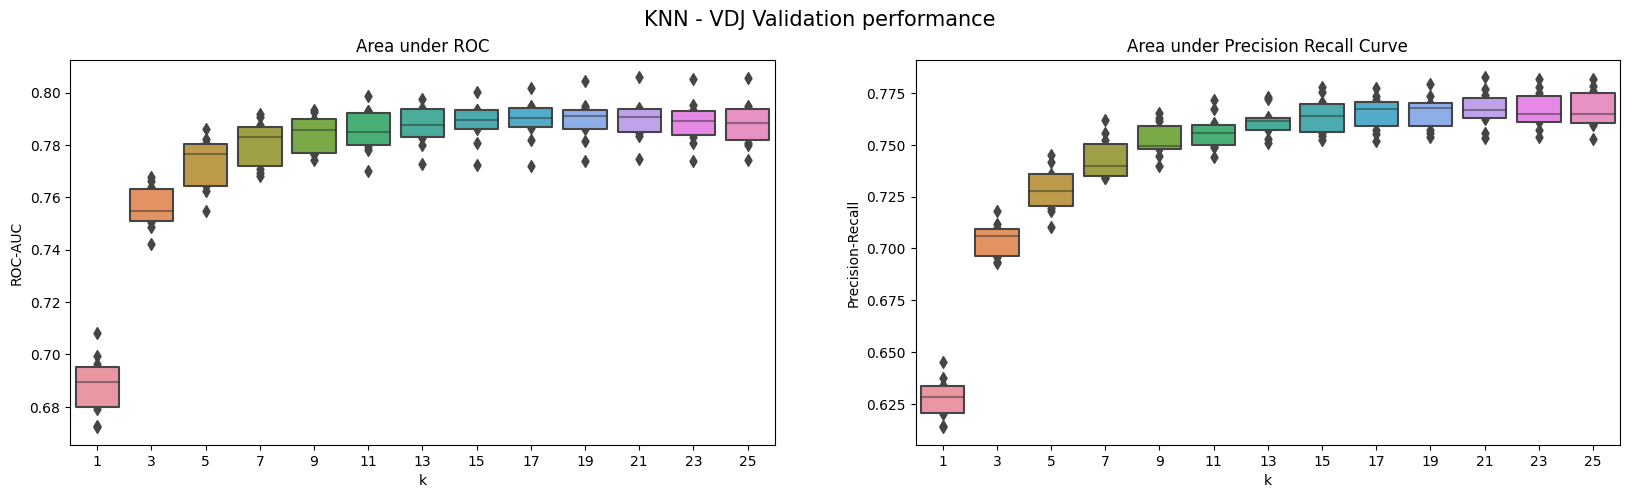

In [23]:
import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
from pytoda.files import read_smi
from sklearn.metrics import (
    accuracy_score, auc, average_precision_score, balanced_accuracy_score,
    confusion_matrix, matthews_corrcoef, precision_score, roc_curve
)

# Arguments to pass
logger = logging.getLogger('knn_prediction')
logging.getLogger('matplotlib.font_manager').disabled = True



import sys
from source.models import knn
from source.utils.plot_knn import plot_roc_prc
from source.utils.utils import cutoff_youdens_j

logger = logging.getLogger('knn_prediction')
logging.getLogger('matplotlib.font_manager').disabled = True

data_path = "data/preprocessed/tcr_split/"
train_name = "train.csv"
test_name = "test.csv"
num_folds = 10

results_path = "results/knn_model/"
k = 25
test_epitope_fp = '.'
test_tcr_fp = '.'

# All the available datapoints from datasets
epitope_fp = "data/raw/epitopes.csv"
tcr_fp = "data/raw/tcr.csv"

# In the main function 

# Function read a .smi (or .csv file with tab-separated values) in a pd.DataFrame.
train_epi = read_smi(epitope_fp, names=['data'])
train_tcr = read_smi(tcr_fp, names=['data'])

test_epi = train_epi if test_epitope_fp == '.' else read_smi(
    test_epitope_fp, names=['data']
)
test_tcr = train_tcr if test_tcr_fp == '.' else read_smi(
    test_tcr_fp, names=['data']
)

# Create right amount of empty lists
all_results = np.empty((np.ceil(k / 2).astype(int), 0)).tolist()

# Original code
for fold in range(num_folds):
    train_data = pd.read_csv(
        os.path.join(data_path, f'fold{fold}', train_name), index_col=0
    )
    test_data = pd.read_csv(
        os.path.join(data_path, f'fold{fold}', test_name), index_col=0
    )
    train_epitopes = train_epi.loc[train_data['ligand_name']]['data']
    train_tcrs = train_tcr.loc[train_data['sequence_id']]['data']
    test_epitopes = test_epi.loc[test_data['ligand_name']]['data']
    test_tcrs = test_tcr.loc[test_data['sequence_id']]['data']
    train_labels = train_data['label']
    test_labels = test_data['label']
    # logger.info(f'Fold {fold}: Data loaded')
    # Classify data
    predictions, knn_labels = knn(
        train_epitopes,
        train_tcrs,
        train_labels,
        test_epitopes,
        test_tcrs,
        k=k,
        return_knn_labels=True,
    )
    logger.info(f'Fold {fold}: Predictions done')

    for idx, _k in enumerate(range(k, 0, -2)):
        # Overwrite predictions to match _k instead of k
        predictions = [
            np.mean(sample_knns[:_k]) for sample_knns in knn_labels
        ]
        # Compute metrics
        #   Continuous metrics
        fpr, tpr, thresholds = roc_curve(test_labels, predictions)
        roc_auc = auc(fpr, tpr)
        precision_recall_score = average_precision_score(
            test_labels, predictions
        )
        #   Metrics for a truly binary classifier
        theta = cutoff_youdens_j(fpr, tpr, thresholds)
        binary_predictions = [p > theta for p in predictions]
        accuracy = accuracy_score(test_labels, binary_predictions)
        balanced_accuracy = balanced_accuracy_score(
            test_labels, binary_predictions
        )
        precision = precision_score(test_labels, binary_predictions)
        mcc = matthews_corrcoef(test_labels, binary_predictions)
        tn, fp, fn, tp = confusion_matrix(test_labels,
                                            binary_predictions).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        if _k != 1:
            # Needed to handle NaN case.
            assert max(
                0, precision == (tp / (tp + fp))
            ), 'Metrics dont match.'
        # Create and save json
        results = {
            'ROC-AUC': roc_auc,
            'Precision-Recall': precision_recall_score,
            'MCC': mcc,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Accuracy': accuracy,
            'Balanced Accuracy': balanced_accuracy,
            'Precision': precision,
            'theta': theta,
        }
        print(results)

        # Write data
        os.makedirs(os.path.join(results_path, f'k={_k}'), exist_ok=True)
        with open(
            os.path.join(
                results_path, f'k={_k}', f'fold{fold}_report.json'
            ), 'w'
        ) as f:
            json.dump(results, f)
        all_results[idx].append(results)
        # Save predictions
        pd.DataFrame(
            {
                'labels': test_labels,
                'predictions': predictions,
                'predicted_label': binary_predictions,
            }
        ).to_csv(
            os.path.join(
                results_path, f'k={_k}', f'fold{fold}_results.csv'
            )
        )
    logger.info(f'Fold {fold}: Reports generated and saved.')
# Generate reports across folds
for idx, _k in enumerate(range(k, 0, -2)):
    df = pd.DataFrame(all_results[idx])
    df.index = range(num_folds)
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df.to_csv(os.path.join(results_path, f'knn_{_k}_cv_results.csv'))
plot_roc_prc(results_path)